In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH-uWfdEZxhvia6nARj0Q6jDuZL-6lhFjpYqPIcA10Q9XKbqNnxPOQ
Mounted at /content/drive


In [ ]:
#!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
assert torch.__version__.startswith("1.6")
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
%cd drive/My Drive

/content/drive/My Drive


In [ ]:
%cd cyc1440/

/content/drive/My Drive/cyc1440


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances('cyclone_ds_train', {}, 'train.json', 'train')

In [ ]:
cyclone_metadata = MetadataCatalog.get('cyclone_ds_train')

In [ ]:
dataset_dicts = DatasetCatalog.get('cyclone_ds_train')

[09/08 22:35:56 d2.data.datasets.coco]: Loading train.json takes 1.17 seconds.
[09/08 22:35:56 d2.data.datasets.coco]: Loaded 3975 images in COCO format from train.json


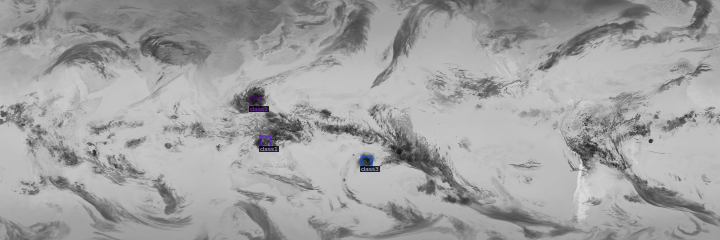

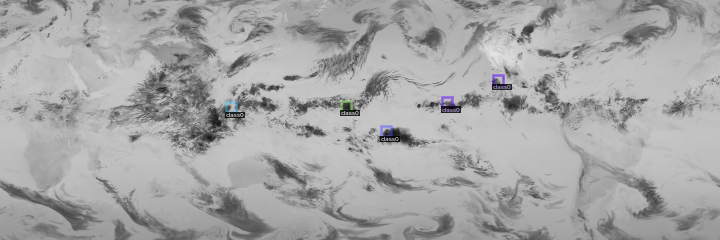

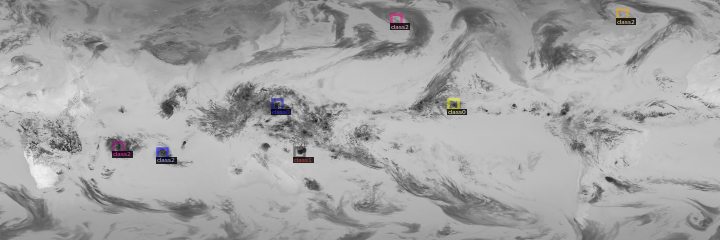

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cyclone_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(
#     "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
# )
cfg.DATASETS.TRAIN = ("cyclone_ds_train",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = (
    2000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 3 classes (data, fig, hazelnut)
cfg.INPUT.MAX_SIZE_TEST = 1440
cfg.INPUT.MAX_SIZE_TRAIN = 1440
cfg.INPUT.MIN_SIZE_TEST = 481
cfg.INPUT.MIN_SIZE_TRAIN = 481
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[30,40,50,60]]


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/08 22:36:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:09, 11.3MB/s]                           


[09/08 22:36:38 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_beta           of shape (64,)
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_mean    loaded from res2_0_branch2a_bn_running_mean   of shape (64,)
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.running_var     loaded from res2_0_branch2a_bn_running_var    of shape (64,)
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_gamma          of shape (64,)
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.weight               loaded from res2_0_branch2a_w                 of shape (64, 64, 1, 1)
[09/08 22:36:38 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv2.norm.bias         

/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[09/08 22:37:35 d2.utils.events]:  eta: 0:37:26  iter: 19  total_loss: 1.524  loss_cls: 0.664  loss_box_reg: 0.005  loss_rpn_cls: 0.699  loss_rpn_loc: 0.195  time: 1.1331  data_time: 1.5152  lr: 0.000040  max_mem: 2029M
[09/08 22:37:58 d2.utils.events]:  eta: 0:36:57  iter: 39  total_loss: 0.998  loss_cls: 0.189  loss_box_reg: 0.002  loss_rpn_cls: 0.684  loss_rpn_loc: 0.124  time: 1.1286  data_time: 0.0067  lr: 0.000080  max_mem: 2029M
[09/08 22:38:21 d2.utils.events]:  eta: 0:36:28  iter: 59  total_loss: 0.893  loss_cls: 0.158  loss_box_reg: 0.001  loss_rpn_cls: 0.660  loss_rpn_loc: 0.076  time: 1.1265  data_time: 0.0068  lr: 0.000120  max_mem: 2029M
[09/08 22:38:43 d2.utils.events]:  eta: 0:36:00  iter: 79  total_loss: 0.938  loss_cls: 0.225  loss_box_reg: 0.001  loss_rpn_cls: 0.614  loss_rpn_loc: 0.108  time: 1.1249  data_time: 0.0060  lr: 0.000160  max_mem: 2029M
[09/08 22:39:05 d2.utils.events]:  eta: 0:35:34  iter: 99  total_loss: 0.818  loss_cls: 0.214  loss_box_reg: 0.002  loss

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
# cfg.merge_from_file(
#     "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
# )
cfg.DATASETS.TRAIN = ("cyclone_ds_train",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = (
    2000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 3 classes (data, fig, hazelnut)
cfg.INPUT.MAX_SIZE_TEST = 1440
cfg.INPUT.MAX_SIZE_TRAIN = 1440
cfg.INPUT.MIN_SIZE_TEST = 481
cfg.INPUT.MIN_SIZE_TRAIN = 481
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[30,40,50,60]]


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/01 19:19:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
#register_coco_instances('cyclone_ds_val', {}, '/content/drive/My Drive/cyc1440/val1.json', '/content/drive/My Drive/local1440/val')
register_coco_instances('cyclone_ds_val', {}, 'val.json', 'val')

NameError: ignored

In [ ]:
val_metadata = MetadataCatalog.get('cyclone_ds_val')
val_dicts = DatasetCatalog.get('cyclone_ds_val')

[09/01 19:31:05 d2.data.datasets.coco]: Loaded 1439 images in COCO format from val.json


In [ ]:
#print(cfg.OUTPUT_DIR)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = '/content/drive/My Drive/cyc1440/output/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
cfg.DATASETS.TEST = ("cyclone_ds_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    # v = Visualizer(im[:, :, ::-1],
    #                metadata=val_metadata, 
    #                scale=0.8, 
    #                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    # )
    # v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])

{'instances': Instances(num_instances=7, image_height=481, image_width=1440, fields=[pred_boxes: Boxes(tensor([[430.4713, 216.6411, 447.4064, 233.4466],
        [431.2613, 209.3067, 448.5616, 225.3849],
        [422.6692, 208.2135, 440.4493, 225.7114],
        [437.2796, 150.5459, 456.7197, 170.3098],
        [822.2440, 199.7668, 840.5150, 217.6762],
        [822.0463, 191.8493, 840.5544, 209.8519],
        [438.7162, 206.9665, 456.6638, 223.9406]], device='cuda:0')), scores: tensor([0.6187, 0.5960, 0.5337, 0.5148, 0.5133, 0.5125, 0.5021],
       device='cuda:0'), pred_classes: tensor([0, 0, 0, 1, 0, 0, 0], device='cuda:0')])}
{'instances': Instances(num_instances=4, image_height=481, image_width=1440, fields=[pred_boxes: Boxes(tensor([[1141.1171,  213.4127, 1159.6901,  232.1223],
        [1118.9883,  159.5373, 1137.7361,  177.8156],
        [ 825.5429,  157.2537,  845.5635,  176.9265],
        [1109.9683,  166.9036, 1128.3577,  184.4768]], device='cuda:0')), scores: tensor([0.5909, 0.